# 🍎 Virtual Physics Lab: Newton's Second Law & Friction

<div class="alert alert-info">
This notebook is an interactive laboratory. You will generate your own experimental data, perform manual and automated linear regressions, and conduct a formal error analysis.
</div>

<hr style="border: 5px solid #003262;" />

## 🔸 Goals of This Notebook

This notebook will help you:
- **Explore Newton's Second Law** by analyzing experimental data from a cart on a horizontal plane
- **Learn data analysis techniques** including manual and automated linear regression
- **Master error analysis** by calculating accuracy (percent error) and precision (standard deviation of residuals)


<hr style="border: 5px solid #003262;" />

## 🔸 The Physics Experiment: Cart on a Horizontal Plane

### 🔹 Experimental Setup

Imagine a cart sitting on a **horizontal track** (completely flat, no incline). You apply a force to the cart, and it accelerates along the track. However, friction between the cart and the track opposes the motion.

<img src="https://github.com/CalCoRE/show-your-work/blob/main/images/physics_diagram.jpg?raw=true" width="150">

### 🔹 The Physics Behind It

When you push the cart, Newton's Second Law tells us:

**F_net = ma**

But the net force isn't just your applied force—it's your applied force minus the friction:

**F_applied - F_friction = ma**

Rearranging this, we get:

**F_applied = ma + F_friction**

This is the key relationship we'll explore! Notice that:
- **F_applied** is what you control (you decide how hard to push)
- **a** is what you measure (how fast the cart accelerates)
- **m** (mass) and **F_friction** are what you're trying to discover from the data

### 🔹 What You'll Do

In this virtual lab, you'll:
1. Apply different forces to the cart and measure the resulting accelerations
2. Collect force-acceleration data points (with some measurement noise, just like real experiments!)
3. Use linear regression to find the best-fit line through your data
4. Extract the mass (from the slope) and friction (from the y-intercept) from that line


In [5]:
# Install required packages if not already installed
import sys
import subprocess

packages = ['numpy', 'pandas', 'matplotlib', 'ipywidgets', 'scipy']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"{package} installed successfully!")

print("All packages are ready!")


All packages are ready!


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, FancyBboxPatch
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from scipy.stats import linregress
import time
import plotly.graph_objects as go

# Setup for interactive plotting
%matplotlib widget
%run engine.ipynb

plt.rcParams['animation.html'] = 'jshtml'

ModuleNotFoundError: No module named 'plotly'

NameError: name 'show_cart_diagram' is not defined

<hr style="border: 5px solid #003262;" />

## Part 0: The Virtual Friction Lab

**Goal:** Generate "messy" experimental data. 

The sliders below let you set the "Hidden Truths" of your experiment—the actual values that you'll try to discover through data analysis later.

Adjust the sliders to set:
- **True Mass:** The actual weight of your cart (in kilograms).
- **Friction:** The force of friction opposing motion (in Newtons).
- **Noise Level:** How much error your virtual sensors have.

<br>

---

### 🔸 Step 1: Choose Your Parameters

**What to do:**
1. Run the code cell below to display the interactive sliders.
2. Adjust each slider to choose values for True Mass, Friction, and Noise Level.

**💡 Tip:** Try different combinations! You can always come back and change them.

In [3]:
# Step 1: Choose parameters
show_sliders()


FloatSlider(value=1.2, continuous_update=False, description='Mass (kg)', max=4.0, min=0.3, step=0.3)

FloatSlider(value=1.5, continuous_update=False, description='Friction (N)', max=5.0, step=0.5)

Button(button_style='info', description='🔧 Build Experiment', style=ButtonStyle())

---

### 🔸 Step 2: Run the Experiment

**What to do:**
1. Run the code cell below to start the experiment.
2. The experiment will generate data points with measurement noise (based on your Noise Level setting).

**💡 Remember:** In a real experiment, you wouldn't know the "true" mass and friction values. You only see the measured data points. Later, you'll work backwards from this data to figure out what those values must be.


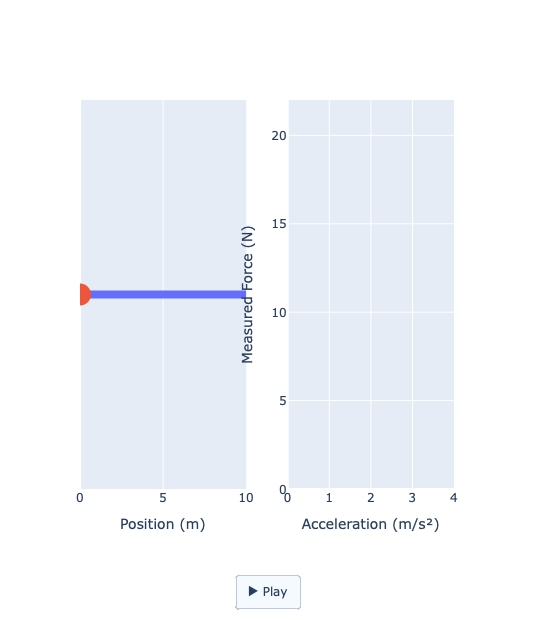

In [5]:
# Step 2: Run the experiment
show_plot()

---

### 🔸 Step 3: Save Your Data

After running the experiment, save your data into a **dataframe** (a data table) so you can analyze it in the next parts.

**What is a dataframe?**
A dataframe is a structured way to store data in rows and columns—like a spreadsheet. In computational notebooks, dataframes are the standard way to work with experimental data.

**What to do:**
1. Run the code cell below to retrieve your experimental data and save it into a dataframe called `df_lab`.
2. The code will display the data table so you can see what was recorded.

**💡 Important:** Make sure you see data in the table! If the table is empty, go back and run Step 2 again.


In [6]:
df_lab = get_df_lab()
df_lab

,acceleration,force,mass,friction
0,0.100000,1.419511,1.2,1.5
1,0.522222,2.394638,1.2,1.5
2,0.944444,2.502490,1.2,1.5
3,1.366667,3.057201,1.2,1.5
4,1.788889,3.568532,1.2,1.5
5,2.211111,4.214591,1.2,1.5
6,2.633333,4.812169,1.2,1.5
7,3.055556,5.464984,1.2,1.5
8,3.477778,4.824879,1.2,1.5
9,3.900000,5.732057,1.2,1.5


<hr style="border: 5px solid #003262;" />

## Part 1: Human vs. Machine

**Goal:** Find the best-fit line. Use the sliders to manually match the data, then let the computer find the mathematical "Least Squares" fit.

<br>

---

### 🔸 Understanding the Physics

Before we begin finding the best-fit line, let's understand what we're working with.

#### 🔹 The Physics Formula

In our experiment with a cart on a horizontal plane, we're exploring Newton's Second Law of Motion. When we apply a force to the cart, it accelerates. However, friction also acts on the cart, opposing its motion. 

The relationship between force and acceleration can be expressed as:

**F = ma + F_friction**

Where:
- **F** is the total force applied to the cart (in Newtons, N)
- **m** is the mass of the cart (in kilograms, kg)
- **a** is the acceleration of the cart (in meters per second squared, m/s²)
- **F_friction** is the force of friction opposing the motion (in Newtons, N)

#### 🔹 The Experiment

In Part 0, you generated experimental data by applying different forces to a cart and measuring the resulting accelerations. Your virtual sensors recorded pairs of values: for each acceleration you measured, you also recorded the force that was applied. 

This is the typical setup for a physics lab experiment—you control one variable (force) and measure the response (acceleration).

#### 🔹 Working Backwards

Here's the key insight: In the real experiment, you don't directly know the mass of the cart or the amount of friction. Instead, you have a collection of force-acceleration data points. 

**Your task is to work backwards from this data to determine (or "guess") what the mass and friction values must be.**

If we rearrange our physics formula slightly, we can see it as a linear relationship:

**F = m × a + F_friction**

This looks like the familiar equation for a line: **y = mx + b**, where:
- **y** (force) depends on
- **x** (acceleration)
- **m** (the slope) represents the mass
- **b** (the y-intercept) represents the friction force

#### 🔹 Finding the Best-Fit Line

To determine the mass and friction from your experimental data, you need to find the line that best fits through your data points. The slope of that line will tell you the mass, and where it crosses the y-axis will tell you the friction. 

In this part, you'll first try to find this line manually using sliders, then see how a computer can find it mathematically.

In [7]:
def plot_manual_fit(guess_m, guess_b):
    if df_lab.empty:
        print("Please run the experiment in Part 0 first!")
        return

    # 🔑 Close previous figure to avoid accumulation
    plt.close("all")

    x = df_lab["acceleration"]
    y = df_lab["force"]
    y_guess = guess_m * x + guess_b

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color="black", label="Experimental Data")
    plt.plot(x, y_guess, color="blue", label="Your Guess (Human)")

    # Residuals
    for i in range(len(x)):
        plt.vlines(
            x[i], y_guess[i], y[i],
            color="red", linestyle="--", alpha=0.5
        )

    plt.title("Manual Fit: Adjust Sliders to Minimize Red Lines")
    plt.xlabel("Acceleration (m/s²)")
    plt.ylabel("Force (N)")
    plt.legend()
    plt.show()


x = df_lab["acceleration"]
y = df_lab["force"]

# Rough scale estimates
est_m = (y.max() - y.min()) / (x.max() - x.min())
est_b = y.min()

guess_m_slider = widgets.FloatSlider(
    value=round(est_m, 2),
    min=0.2 * est_m,
    max=2.0 * est_m,
    step=0.01,
    description="Guess Mass",
    continuous_update=False
)

guess_b_slider = widgets.FloatSlider(
    value=round(est_b, 2),
    min=0.0,
    max=max(y.max(), 2 * est_b),
    step=0.01,
    description="Guess Friction",
    continuous_update=False
)
widgets.interact(
    plot_manual_fit,
    guess_m=guess_m_slider,
    guess_b=guess_b_slider
)


interactive(children=(FloatSlider(value=1.13, continuous_update=False, description='Guess Mass', max=2.2697609…

<function __main__.plot_manual_fit(guess_m, guess_b)>


<hr style="border: 1px solid #fdb515;" />

### 🔸 Understanding Linear Regression

Now that you've tried fitting the line manually, let's understand what linear regression does at a high level.

#### 🔹 What is Linear Regression?

Linear regression is a mathematical method for finding the best straight line that fits through a set of data points. When you have data that appears to follow a linear pattern (like our force-acceleration relationship), linear regression finds the line that minimizes the overall "error" between the line and your actual data points.

#### 🔹 How Does It Work?

Think about what you just did with the sliders: you tried to adjust the slope (mass) and y-intercept (friction) to make the blue line pass as close as possible to all the black data points. 

You probably noticed that it's impossible to make the line pass through every point perfectly—there's always some distance between the line and each point. Those red vertical lines you saw represent these distances, called **"residuals."**

Linear regression does exactly what you were trying to do, but it uses mathematics to find the optimal values automatically. Specifically, it uses a method called **"least squares,"** which finds the line that minimizes the sum of the squares of all those residual distances. 

**Why squares?** Squaring the distances ensures that:
1. All distances are positive (so they don't cancel each other out)
2. Larger errors are penalized more heavily (a point that's far from the line contributes more to the total error)

#### 🔹 What Does It Give Us?

When linear regression analyzes your force-acceleration data, it calculates:
- **The slope (m)**: This tells us the mass of the cart
- **The y-intercept (b)**: This tells us the force of friction
- **A measure of fit quality**: How well the line matches the data (often expressed as R², which ranges from 0 to 1, with 1 being a perfect fit)

#### 🔹 Why Use It?

While you can get close by eye and with sliders, linear regression gives you the mathematically optimal answer. It's also fast, consistent, and can handle much larger datasets than you could analyze manually. 

This is why scientists and engineers use computational tools for data analysis—they provide precise, reproducible results.

---


### The "Machine" Fit
Now we run `scipy.stats.linregress`. The computer minimizes the **sum of the squares** of those red lines you saw above.

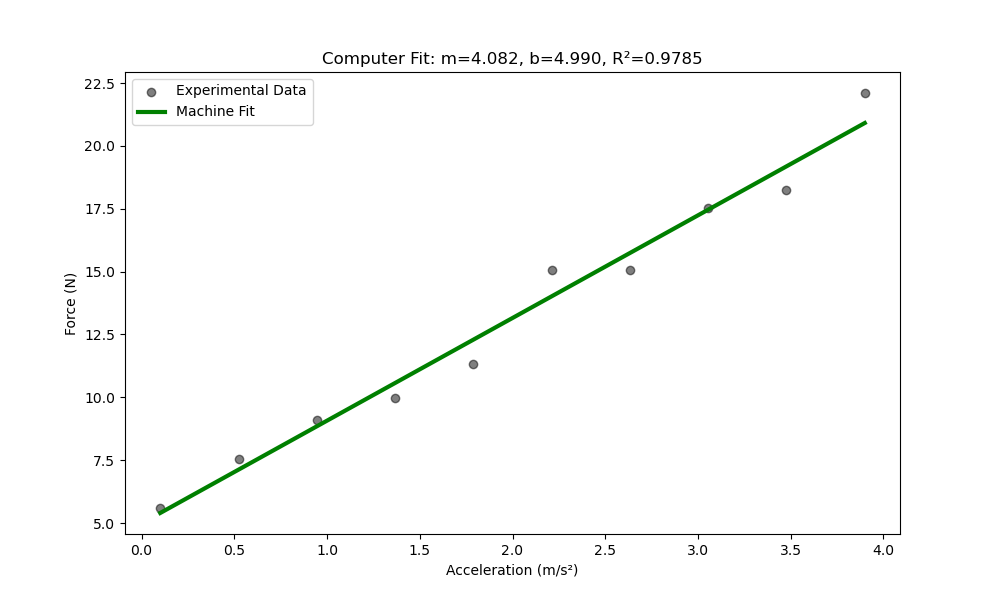

In [18]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

res = linregress(df_lab["acceleration"], df_lab["force"])
m_comp, b_comp = res.slope, res.intercept

plt.close("all")
plt.figure(figsize=(10, 6))

plt.scatter(
    df_lab["acceleration"],
    df_lab["force"],
    color="black",
    alpha=0.5,
    label="Experimental Data"
)

plt.plot(
    df_lab["acceleration"],
    m_comp * df_lab["acceleration"] + b_comp,
    color="green",
    linewidth=3,
    label="Machine Fit"
)

plt.title(
    f"Computer Fit: m={m_comp:.3f}, "
    f"b={b_comp:.3f}, "
    f"R²={res.rvalue**2:.4f}"
)
plt.xlabel("Acceleration (m/s²)")
plt.ylabel("Force (N)")
plt.legend()
plt.show()


## Part 2: Interactive Error Analysis
### Task A: Accuracy (Percent Error)
Fill in the formula below to calculate how close your experimental mass was to the true value.

In [8]:
experimental_mass = m_comp
true_mass = true_values['mass']

# STUDENT TASK: Complete the formula
percent_error = abs(experimental_mass - true_mass) / true_mass * 100

print(f"Experimental Mass: {experimental_mass:.3f} kg")
print(f"True Mass: {true_mass:.3f} kg")
print(f"Percent Error: {percent_error:.2f}%")

NameError: name 'm_comp' is not defined

### Task B: Precision (Standard Deviation of Residuals)
How "spread out" is the noise? High precision means the points are very close to the line.

In [ ]:
# Calculate the individual mistakes (residuals)
df_lab['residual'] = df_lab['Force_Measured'] - (m_comp * df_lab['Acceleration'] + b_comp)

# STUDENT TASK: Calculate the standard deviation of residuals
uncertainty = df_lab['residual'].std()

print(f"Uncertainty (Precision): ±{uncertainty:.3f} N")

### Task C: Visualizing the "Uncertainty Band"
Observe the shaded zone. This is the range where we expect our data to fall.

In [ ]:
x = df_lab['Acceleration']
y_fit = m_comp * x + b_comp

plt.figure(figsize=(10, 6))
plt.scatter(x, df_lab['Force_Measured'], color='black')
plt.plot(x, y_fit, color='green')

# Draw the uncertainty band
plt.fill_between(x, y_fit - uncertainty, y_fit + uncertainty, color='green', alpha=0.2, label='Uncertainty Zone')

plt.title("The Confidence Band (Precision Visualized)")
plt.legend()
plt.show()

print("Aha! Moment: Go back to Part 0, increase the 'Noise' slider, and re-run everything. Watch the green zone expand!")

# Run this cell to see your final calculated friction value
print(f"Your measured Force of Friction is: {b_comp:.3f} Newtons")
print(f"The 'True' Friction you set was: {true_values['friction']:.3f} Newtons")